In [1]:
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm
import talib

In [2]:
data_dir = os.path.join('..', 'data',  'BTCUSDT', '1h')

In [3]:
data_config = {
  'data_dir': os.path.join('..', 'data',  'BTCUSDT'),
  'names': ["open time", "open", "high", "low", "close", "volume",
            "close time", "quote asset volume", "number of trades",
            "taker buy base asset volume", "taker buy quote asset volume", "date"],
  'columns': ["open time", "open", "high", "low", "close", "volume"], 
  'start_date': '2017-08', 
  'end_date': '2022-06', 
  'start_date_training': '2018-01-01',
  'ticker': 'BTCUSDT',
  'interval': '1h', 
}

class DataLoader():
    def __init__(self, config):
        self.config = config
        self.data = self.load_data()
        
    def load_data(self):
        """
            Load data and return prepared data frame
        """
        df = pd.DataFrame()
        for d in tqdm(pd.date_range(self.config['start_date'], self.config['end_date'], freq='M')):
            temp_dir = os.path.join(self.config['data_dir'], self.config['interval'],
                                    '{}-{}-{}-{:02}.zip'.format(self.config['ticker'],
                                                         self.config['interval'], 
                                                         d.year, 
                                                         d.month))
            df = df.append(pd.read_csv(temp_dir, names=self.config['names']))
        
        df = df[self.config['columns']]
        df['date'] = pd.to_datetime(df['open time'], unit='ms')
        df = df.sort_values(by = 'date')
        
        d1 = df['date'].to_list()[0]
        d2 = df['date'].to_list()[-1]
        
        df = df.set_index('date')
        df = df.reindex(pd.date_range(d1, d2, freq='H')).fillna(method = 'ffill')
        
        #df["log_return"] = np.log(df['close'] / df['close'].shift(1))
        df["return"] = df['close'].pct_change()
        df = df.drop('open time', axis=1)
        return df
    
    def generate_features(self):
        
        for i in [5, 10, 15, 20]:
            self.data[f'MA_{i}'] = talib.MA(self.data['close'], timeperiod=i)
            self.data[f'MA_{i}'] = self.data[f'MA_{i}']/self.data['close']
        
        for i in [7, 14, 21]:
            self.data[f'RSI_{i}'] = talib.RSI(self.data['close'], timeperiod=i)
            self.data[f'MFI_{i}'] = talib.MFI(self.data['high'],
                                              self.data['low'],
                                              self.data['close'],
                                              self.data['volume'],
                                              timeperiod=i)
        
        self.data['target_return'] = self.data['return'].shift(-1)
        self.data['target'] = self.data['target_return'].apply(lambda x: 1 if x > 0 else 0)
        self.data = self.data.dropna() 
        self.data = self.data[self.data.index >= pd.to_datetime(self.config['start_date_training'])]
        
        

In [4]:
dt = DataLoader(data_config)
dt.generate_features()
dt.data.head(10)

  0%|          | 0/58 [00:00<?, ?it/s]

,open,high,low,close,volume,return,MA_5,MA_10,MA_15,MA_20,RSI_7,MFI_7,RSI_14,MFI_14,RSI_21,MFI_21,target_return,target
2018-01-01 00:00:00,13715.65,13715.65,13400.01,13529.01,443.356199,-0.013659,1.019717,1.014913,0.999011,0.982319,47.730214,42.968171,53.515629,73.661739,52.353109,59.644207,-0.024093,0
2018-01-01 01:00:00,13528.99,13595.89,13155.38,13203.06,383.697006,-0.024093,1.033244,1.039896,1.025260,1.008664,34.785584,26.862775,46.723138,67.514217,48.172120,60.358923,0.009628,1
2018-01-01 02:00:00,13203.00,13418.43,13200.00,13330.18,429.064572,0.009628,1.014227,1.026185,1.017185,1.002000,41.948934,25.302426,49.419505,60.196452,49.813377,60.458456,0.005990,1
2018-01-01 03:00:00,13330.26,13611.27,13290.00,13410.03,420.087030,0.005990,1.002065,1.017442,1.012908,0.998318,46.273743,27.097108,51.093868,59.857941,50.840150,65.114369,0.014242,1
2018-01-01 04:00:00,13434.98,13623.29,13322.15,13601.01,340.807329,0.014242,0.986299,1.002155,1.000857,0.988156,55.520270,29.767750,54.936175,58.401578,53.242518,65.060205,-0.003089,0
2018-01-01 05:00:00,13615.20,13699.00,13526.50,13558.99,404.229046,-0.003089,0.989797,1.003630,1.005045,0.995051,53.171265,43.787808,53.932185,65.827881,52.648131,68.935435,0.016330,1
2018-01-01 06:00:00,13539.00,13800.00,13510.00,13780.41,264.989684,0.016330,0.982273,0.986114,0.991643,0.982297,62.837280,53.515346,58.260907,59.920493,55.402794,72.243245,-0.015243,0
2018-01-01 07:00:00,13780.00,13818.55,13555.02,13570.35,292.188777,-0.015243,1.001018,0.998647,1.005688,0.999641,51.151302,56.675655,53.157740,50.252093,52.368106,68.985939,-0.005185,0
2018-01-01 08:00:00,13569.98,13735.24,13400.00,13499.99,271.813553,-0.005185,1.007567,1.001478,1.009631,1.006511,47.685801,59.146879,51.529619,43.582006,51.378336,65.257535,0.008667,1
2018-01-01 09:00:00,13499.97,13670.00,13459.11,13616.99,213.095829,0.008667,0.999145,0.992143,1.000368,0.999548,53.763029,74.383409,54.049913,48.882785,52.931603,63.836444,-0.003450,0


In [5]:
from xgboost import XGBClassifier

trader_config = {
    'features': ['MA_5', 'MA_10', 'MA_15', 'MA_20',
                 'RSI_7', 'MFI_7', 'RSI_14', 'MFI_14',
                 'RSI_21', 'MFI_21'],
    # out of sample start date
    'oos_start_date': '2022-01-01', 
    # look back (training size) in days
    'look_back': 90,
    # training size
    'step': 30,
}

class HourlyBacktester():
    def __init__(self, data, config):
        self.config = config
        self.full_data = data
        self.df_res = None
        
    def get_oos_data(self):
        """
            Returns out-of-sample data
        """
        return self.full_data[self.full_data.index >= pd.to_datetime(self.config['oos_start_date'])]
    
    def get_is_data(self):
        """
            Returns in-sample data
        """
        return self.full_data[self.full_data.index < pd.to_datetime(self.config['oos_start_date'])]
    
    @staticmethod
    def get_model(xgb_param):
        """
            Returns model
        """
        return XGBClassifier(**xgb_param,  objective = 'binary:logistic')
    
    def apply_strategy(self, params, look_back, oos=False):
        """
            The main logic of the strategy
        """
        
        self.config['look_back'] = look_back
        
        if oos:
            df = self.get_oos_data()
            dft = self.get_is_data()
            df = dft[-self.config['look_back']:].append(df)
        else:
            df = self.get_is_data()
            
        self.df_res = pd.DataFrame()
        i = 0
        with tqdm(total = len(df)) as pbar:
            pbar.update(self.config['look_back']*24)
            while True:

                train_start = i*self.config['step']*24
                train_end = train_start + self.config['look_back']*24
                test_end = train_end + self.config['step']*24
                if train_end >= len(df):
                    break

                df_train = df[train_start:train_end]
                df_test = df[train_end:test_end]

                x_tr = df_train[self.config['features']]
                x_test = df_test[self.config['features']]
                y_tr = df_train['target']

                clf = self.get_model(params)
                clf.fit(x_tr, y_tr, eval_metric = 'logloss')

                pred = clf.predict(x_test)
                df_pred = pd.DataFrame({
                    'date': df_test.index,
                    'target_return': df_test['target_return'],
                    'target': df_test['target'],
                    'prediction': pred
                })
                if len(self.df_res):
                    self.df_res = self.df_res.append(df_pred)
                else:
                    self.df_res = df_pred
                pbar.update(self.config['step']*24)
                i+=1
                
    def get_score(self):
        
        self.df_res['hourly_return'] = self.df_res[['target_return', 'target', 'prediction']].apply(
           lambda row: np.abs(row[0]) if row[1] == row[2] else -np.abs(row[0]) , axis=1
        )
        
        self.df_res['cum_ret'] = self.df_res['hourly_return'].cumsum()
        
        return self.df_res['cum_ret'].to_list()[-1]

    def objective(self, trial):
        
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 350, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.10),
            'subsample': trial.suggest_uniform('subsample', 0.50, 0.90),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.50, 0.90),
            'gamma': trial.suggest_int('gamma', 0, 20), 
        }
        
        look_back = trial.suggest_int('look_back', 30, 180)
        
        self.apply_strategy(params, look_back)
        
        return self.get_score()

In [6]:
import optuna
import warnings
import neptune.new as neptune
import neptune.new.integrations.optuna as optuna_utils

warnings.filterwarnings("ignore")

run = neptune.init(
    project="enes.zvornicanin/optuna-test",
    api_token=os.environ.get('OPTUNA-TEST-NEPTUNE-API'),
) 

neptune_callback = optuna_utils.NeptuneCallback(run)

hb = HourlyBacktester(dt.data, trader_config)
n_trials = 20

study = optuna.create_study(direction="maximize")
study.optimize(hb.objective, n_trials=n_trials, callbacks=[neptune_callback])




https://app.neptune.ai/enes.zvornicanin/optuna-test/e/OP-5
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


[I 2022-06-20 17:06:25,157] A new study created in memory with name: no-name-11b95419-ddf1-4a06-b14a-3b8cdcda1c86


  0%|          | 0/35064 [00:00<?, ?it/s]

[I 2022-06-20 17:07:41,041] Trial 0 finished with value: 2.6365490876668782 and parameters: {'n_estimators': 567, 'max_depth': 7, 'learning_rate': 0.01138743644743088, 'subsample': 0.5910529620609777, 'colsample_bytree': 0.7448515469428725, 'gamma': 6, 'look_back': 89}. Best is trial 0 with value: 2.6365490876668782.
[W 2022-06-20 17:07:41,878] Param colsample_bytree unique value length is less than 2.
[W 2022-06-20 17:07:41,892] Param colsample_bytree unique value length is less than 2.
[W 2022-06-20 17:07:41,900] Param colsample_bytree unique value length is less than 2.
[W 2022-06-20 17:07:41,910] Param colsample_bytree unique value length is less than 2.
[W 2022-06-20 17:07:41,920] Param colsample_bytree unique value length is less than 2.
[W 2022-06-20 17:07:41,929] Param colsample_bytree unique value length is less than 2.
[W 2022-06-20 17:07:41,947] Param gamma unique value length is less than 2.
[W 2022-06-20 17:07:41,964] Param gamma unique value length is less than 2.
[W 2022

  0%|          | 0/35064 [00:00<?, ?it/s]

[I 2022-06-20 17:08:33,256] Trial 1 finished with value: 0.35813435035362184 and parameters: {'n_estimators': 607, 'max_depth': 9, 'learning_rate': 0.06237880682856147, 'subsample': 0.5343209978550263, 'colsample_bytree': 0.5614263804274081, 'gamma': 2, 'look_back': 32}. Best is trial 0 with value: 2.6365490876668782.


  0%|          | 0/35064 [00:00<?, ?it/s]

[I 2022-06-20 17:09:11,159] Trial 2 finished with value: 4.821988313189655 and parameters: {'n_estimators': 434, 'max_depth': 4, 'learning_rate': 0.04010298642816986, 'subsample': 0.8381669456266398, 'colsample_bytree': 0.7620025386515892, 'gamma': 12, 'look_back': 51}. Best is trial 2 with value: 4.821988313189655.


  0%|          | 0/35064 [00:00<?, ?it/s]

[I 2022-06-20 17:09:57,517] Trial 3 finished with value: 3.710723094796419 and parameters: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.04975497382022411, 'subsample': 0.5580244739234987, 'colsample_bytree': 0.8436880420421129, 'gamma': 11, 'look_back': 105}. Best is trial 2 with value: 4.821988313189655.


  0%|          | 0/35064 [00:00<?, ?it/s]

[I 2022-06-20 17:12:43,885] Trial 4 finished with value: 1.4311612560849105 and parameters: {'n_estimators': 927, 'max_depth': 7, 'learning_rate': 0.0652522653259008, 'subsample': 0.7793318912153029, 'colsample_bytree': 0.5126976288634035, 'gamma': 9, 'look_back': 128}. Best is trial 2 with value: 4.821988313189655.


  0%|          | 0/35064 [00:00<?, ?it/s]

[I 2022-06-20 17:13:19,568] Trial 5 finished with value: 3.664613065853334 and parameters: {'n_estimators': 711, 'max_depth': 3, 'learning_rate': 0.014200321506155836, 'subsample': 0.6006506987479212, 'colsample_bytree': 0.5143217917534874, 'gamma': 1, 'look_back': 37}. Best is trial 2 with value: 4.821988313189655.


  0%|          | 0/35064 [00:00<?, ?it/s]

[I 2022-06-20 17:16:03,192] Trial 6 finished with value: 1.9795767437138831 and parameters: {'n_estimators': 755, 'max_depth': 9, 'learning_rate': 0.02210500595007934, 'subsample': 0.6944109934609835, 'colsample_bytree': 0.5273672868796756, 'gamma': 9, 'look_back': 124}. Best is trial 2 with value: 4.821988313189655.


  0%|          | 0/35064 [00:00<?, ?it/s]

[I 2022-06-20 17:17:50,793] Trial 7 finished with value: 1.522764996711678 and parameters: {'n_estimators': 538, 'max_depth': 8, 'learning_rate': 0.06396223303946745, 'subsample': 0.7359632501130976, 'colsample_bytree': 0.6496338414601176, 'gamma': 6, 'look_back': 122}. Best is trial 2 with value: 4.821988313189655.


  0%|          | 0/35064 [00:00<?, ?it/s]

[I 2022-06-20 17:20:04,236] Trial 8 finished with value: 1.6621338549250169 and parameters: {'n_estimators': 785, 'max_depth': 7, 'learning_rate': 0.08244293798319904, 'subsample': 0.8426365685779631, 'colsample_bytree': 0.6918544393867455, 'gamma': 7, 'look_back': 122}. Best is trial 2 with value: 4.821988313189655.


  0%|          | 0/35064 [00:00<?, ?it/s]

[I 2022-06-20 17:21:39,973] Trial 9 finished with value: 2.817966257664858 and parameters: {'n_estimators': 980, 'max_depth': 10, 'learning_rate': 0.08398434810756214, 'subsample': 0.6257976551480288, 'colsample_bytree': 0.818063325161848, 'gamma': 0, 'look_back': 55}. Best is trial 2 with value: 4.821988313189655.


  0%|          | 0/35064 [00:00<?, ?it/s]

[I 2022-06-20 17:22:54,624] Trial 10 finished with value: 1.6549798243003688 and parameters: {'n_estimators': 387, 'max_depth': 5, 'learning_rate': 0.03548657475452863, 'subsample': 0.8996351943337283, 'colsample_bytree': 0.7529571384634041, 'gamma': 17, 'look_back': 178}. Best is trial 2 with value: 4.821988313189655.


  0%|          | 0/35064 [00:00<?, ?it/s]

[I 2022-06-20 17:23:27,086] Trial 11 finished with value: 4.286120299493142 and parameters: {'n_estimators': 406, 'max_depth': 3, 'learning_rate': 0.043586694509552985, 'subsample': 0.6857523279301607, 'colsample_bytree': 0.8918623178044063, 'gamma': 14, 'look_back': 80}. Best is trial 2 with value: 4.821988313189655.


  0%|          | 0/35064 [00:00<?, ?it/s]

[I 2022-06-20 17:24:09,003] Trial 12 finished with value: 4.629947189149345 and parameters: {'n_estimators': 360, 'max_depth': 5, 'learning_rate': 0.042158359100504056, 'subsample': 0.6779518227580598, 'colsample_bytree': 0.8983632094834084, 'gamma': 15, 'look_back': 72}. Best is trial 2 with value: 4.821988313189655.


  0%|          | 0/35064 [00:00<?, ?it/s]

[I 2022-06-20 17:24:47,385] Trial 13 finished with value: 5.210315443125857 and parameters: {'n_estimators': 355, 'max_depth': 5, 'learning_rate': 0.0317123218374243, 'subsample': 0.786879421330084, 'colsample_bytree': 0.886074463728819, 'gamma': 20, 'look_back': 59}. Best is trial 13 with value: 5.210315443125857.


  0%|          | 0/35064 [00:00<?, ?it/s]

[I 2022-06-20 17:25:37,493] Trial 14 finished with value: 4.384827222754918 and parameters: {'n_estimators': 462, 'max_depth': 5, 'learning_rate': 0.028691068895127403, 'subsample': 0.8037258416613392, 'colsample_bytree': 0.790966717970618, 'gamma': 19, 'look_back': 57}. Best is trial 13 with value: 5.210315443125857.


  0%|          | 0/35064 [00:00<?, ?it/s]

[I 2022-06-20 17:26:30,064] Trial 15 finished with value: 3.633977538053133 and parameters: {'n_estimators': 637, 'max_depth': 4, 'learning_rate': 0.02414850878343678, 'subsample': 0.8540452405027001, 'colsample_bytree': 0.6698892367417761, 'gamma': 20, 'look_back': 54}. Best is trial 13 with value: 5.210315443125857.


  0%|          | 0/35064 [00:00<?, ?it/s]

[I 2022-06-20 17:27:22,235] Trial 16 finished with value: 3.783288091847585 and parameters: {'n_estimators': 351, 'max_depth': 6, 'learning_rate': 0.03465490975710614, 'subsample': 0.7551852317711564, 'colsample_bytree': 0.6023129836271461, 'gamma': 13, 'look_back': 97}. Best is trial 13 with value: 5.210315443125857.


  0%|          | 0/35064 [00:00<?, ?it/s]

[I 2022-06-20 17:28:30,557] Trial 17 finished with value: 1.2864036246032193 and parameters: {'n_estimators': 465, 'max_depth': 4, 'learning_rate': 0.09979112701397053, 'subsample': 0.823579011259816, 'colsample_bytree': 0.733666759764732, 'gamma': 17, 'look_back': 161}. Best is trial 13 with value: 5.210315443125857.


  0%|          | 0/35064 [00:00<?, ?it/s]

[I 2022-06-20 17:29:27,501] Trial 18 finished with value: 5.029711072029103 and parameters: {'n_estimators': 444, 'max_depth': 6, 'learning_rate': 0.05395073296801107, 'subsample': 0.8754804974592673, 'colsample_bytree': 0.8524895396223497, 'gamma': 17, 'look_back': 66}. Best is trial 13 with value: 5.210315443125857.


  0%|          | 0/35064 [00:00<?, ?it/s]

[I 2022-06-20 17:31:10,770] Trial 19 finished with value: 4.373678616655161 and parameters: {'n_estimators': 832, 'max_depth': 6, 'learning_rate': 0.05645751761800897, 'subsample': 0.8949849334127633, 'colsample_bytree': 0.8418850562727114, 'gamma': 17, 'look_back': 70}. Best is trial 13 with value: 5.210315443125857.


In [7]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/enes.zvornicanin/optuna-test/e/OP-5


In [10]:
best_params = study.best_params
look_back = best_params.pop('look_back')

hb = HourlyBacktester(dt.data, trader_config)
hb.apply_strategy( best_params, look_back)
hb.get_score()

hb.df_res.head()

  0%|          | 0/35064 [00:00<?, ?it/s]

,date,target_return,target,prediction,hourly_return,cum_ret
2018-03-01 00:00:00,2018-03-01 00:00:00,0.000768,1,0,-0.000768,-0.000768
2018-03-01 01:00:00,2018-03-01 01:00:00,-0.008351,0,0,0.008351,0.007582
2018-03-01 02:00:00,2018-03-01 02:00:00,0.002423,1,0,-0.002423,0.005160
2018-03-01 03:00:00,2018-03-01 03:00:00,0.008179,1,0,-0.008179,-0.003019
2018-03-01 04:00:00,2018-03-01 04:00:00,-0.002659,0,0,0.002659,-0.000360


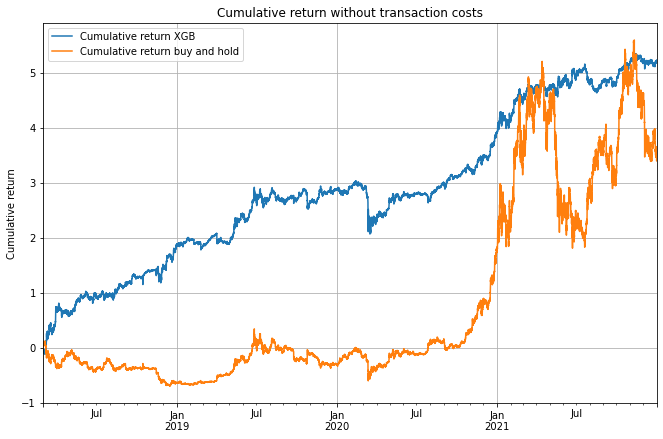

In [18]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (11, 7)
hb.df_res['buy_and_hold_ret'] = (hb.df_res['target_return'] + 1).cumprod() - 1
hb.df_res[['cum_ret', 'buy_and_hold_ret']].plot()
plt.legend(['Cumulative return XGB', 'Cumulative return buy and hold'])
plt.grid()
plt.ylabel('Cumulative return')
plt.title('Cumulative return without transaction costs')
plt.show()

  0%|          | 0/3682 [00:00<?, ?it/s]

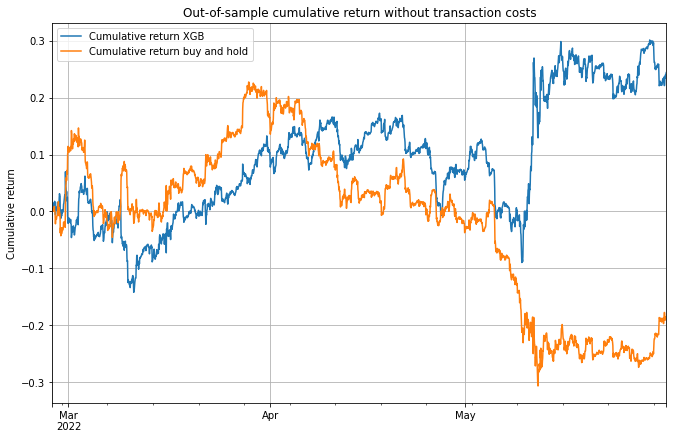

In [19]:
hb = HourlyBacktester(dt.data, trader_config)
hb.apply_strategy( best_params, look_back, oos=True)
hb.get_score()
plt.rcParams["figure.figsize"] = (11, 7)
hb.df_res['buy_and_hold_ret'] = (hb.df_res['target_return'] + 1).cumprod() - 1
hb.df_res[['cum_ret', 'buy_and_hold_ret']].plot()
plt.legend(['Cumulative return XGB', 'Cumulative return buy and hold'])
plt.grid()
plt.ylabel('Cumulative return')
plt.title('Out-of-sample cumulative return without transaction costs')
plt.show()

In [22]:
np.random.rand(10)*100

array([29.84671651, 84.90425853, 34.77259741,  7.25226652, 79.1491207 ,
       32.26845971, 24.36843333,  2.18182695, 28.37176922, 69.72665548])

In [44]:
from unittest.mock import Mock

json = Mock()
json.order = lambda x, z: {"executedQty":1,
                             "cummulativeQuoteQty":np.random.rand()+1}

In [45]:
json.order(1, 2)

{'executedQty': 1, 'cummulativeQuoteQty': 1.565886187579379}

In [28]:
order

<Mock name='mock.loads()' id='2640608167112'>